<h2>Vorticity and Divergence Inversion</h2>

This Notebook demonstrates how to 'invert' relative-vorticity and divergence fields to obtain the horizontal winds uniquely associated with that field (i.e., the non-divergent and irrotational wind components, respectively) over a limited-area domain. 

This example uses a real-time GFS analysis to invert the analyzed 850-hPa relative vorticity and divergence associated with Hurricane Dora (2023) in the Central Pacific.

<hr>

We start by loading the required modules:
<ul>
    <li><b>boto3</b> to access GFS data hosted on Amazon Web Services' S3 NOAA GFS bucket. We also need to import a couple of modules from <b>botocore</b> to access the GFS bucket via boto3 without AWS credentials.</li>
    <li><b>xarray</b> to open and parse the data. Note that an appropriate GRIB decoder such as cfgrib must be installed in order for xarray to be able to read GRIB-formatted data.</li>
    <li><b>metpy</b> to compute the relative vorticity.</li>
    <li><b>matplotlib</b> and <b>cartopy</b> to create maps from the data.</li>
    <li><b>numpy</b> to help with various mathematical operations (e.g., evenly spaced lat/lon lines for maps).</li>
    <li><b>os</b>, specifically the <i>path</i> function, to check to see if the desired GFS data already exist locally.</li>
</ul>

In [1]:
import os.path
import xarray as xr
import numpy as np
import boto3
import metpy.calc as mpcalc
from botocore import UNSIGNED
from botocore.config import Config
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.ticker as mticker
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

We'll now download the desired GFS analysis - here being the 1200 UTC 9 August 2023 analysis. We use the 0.5° analysis to save computational time. This is just shy of 150 MB, so it may take a minute to download on slower connections. We use os.path to check to see if this file has already been downloaded so we can skip this step if needed.

In [2]:
if(not os.path.isfile('gfs.t12z.pgrb2.0p50.f000')):
    client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    client.download_file('noaa-gfs-bdp-pds', 'gfs.20230809/12/atmos/gfs.t12z.pgrb2.0p50.f000', 'gfs.t12z.pgrb2.0p50.f000')

Let's open the data into two arrays, one for the 850 hPa <i>u</i> wind component and one for the 850 hPa <i>v</i> wind component:

In [3]:
u850 = xr.open_dataset('gfs.t12z.pgrb2.0p50.f000', engine='cfgrib', filter_by_keys={'typeOfLevel': 'isobaricInhPa', 'shortName': 'u', 'level': 850})
u = u850.u
v850 = xr.open_dataset('gfs.t12z.pgrb2.0p50.f000', engine='cfgrib', filter_by_keys={'typeOfLevel': 'isobaricInhPa', 'shortName': 'v', 'level': 850})
v = v850.v

Now that we've opened our dataset, let's create a plot of 850 hPa relative vorticity over a limited region corresponding to Hurricane Dora.

/opt/tljh/user/lib/python3.7/site-packages/metpy/xarray.py:354: UserWarning: More than one time coordinate present for variable "u".
  + varname + '.')
/opt/tljh/user/lib/python3.7/site-packages/pint/quantity.py:1309: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/opt/tljh/user/lib/python3.7/site-packages/carto

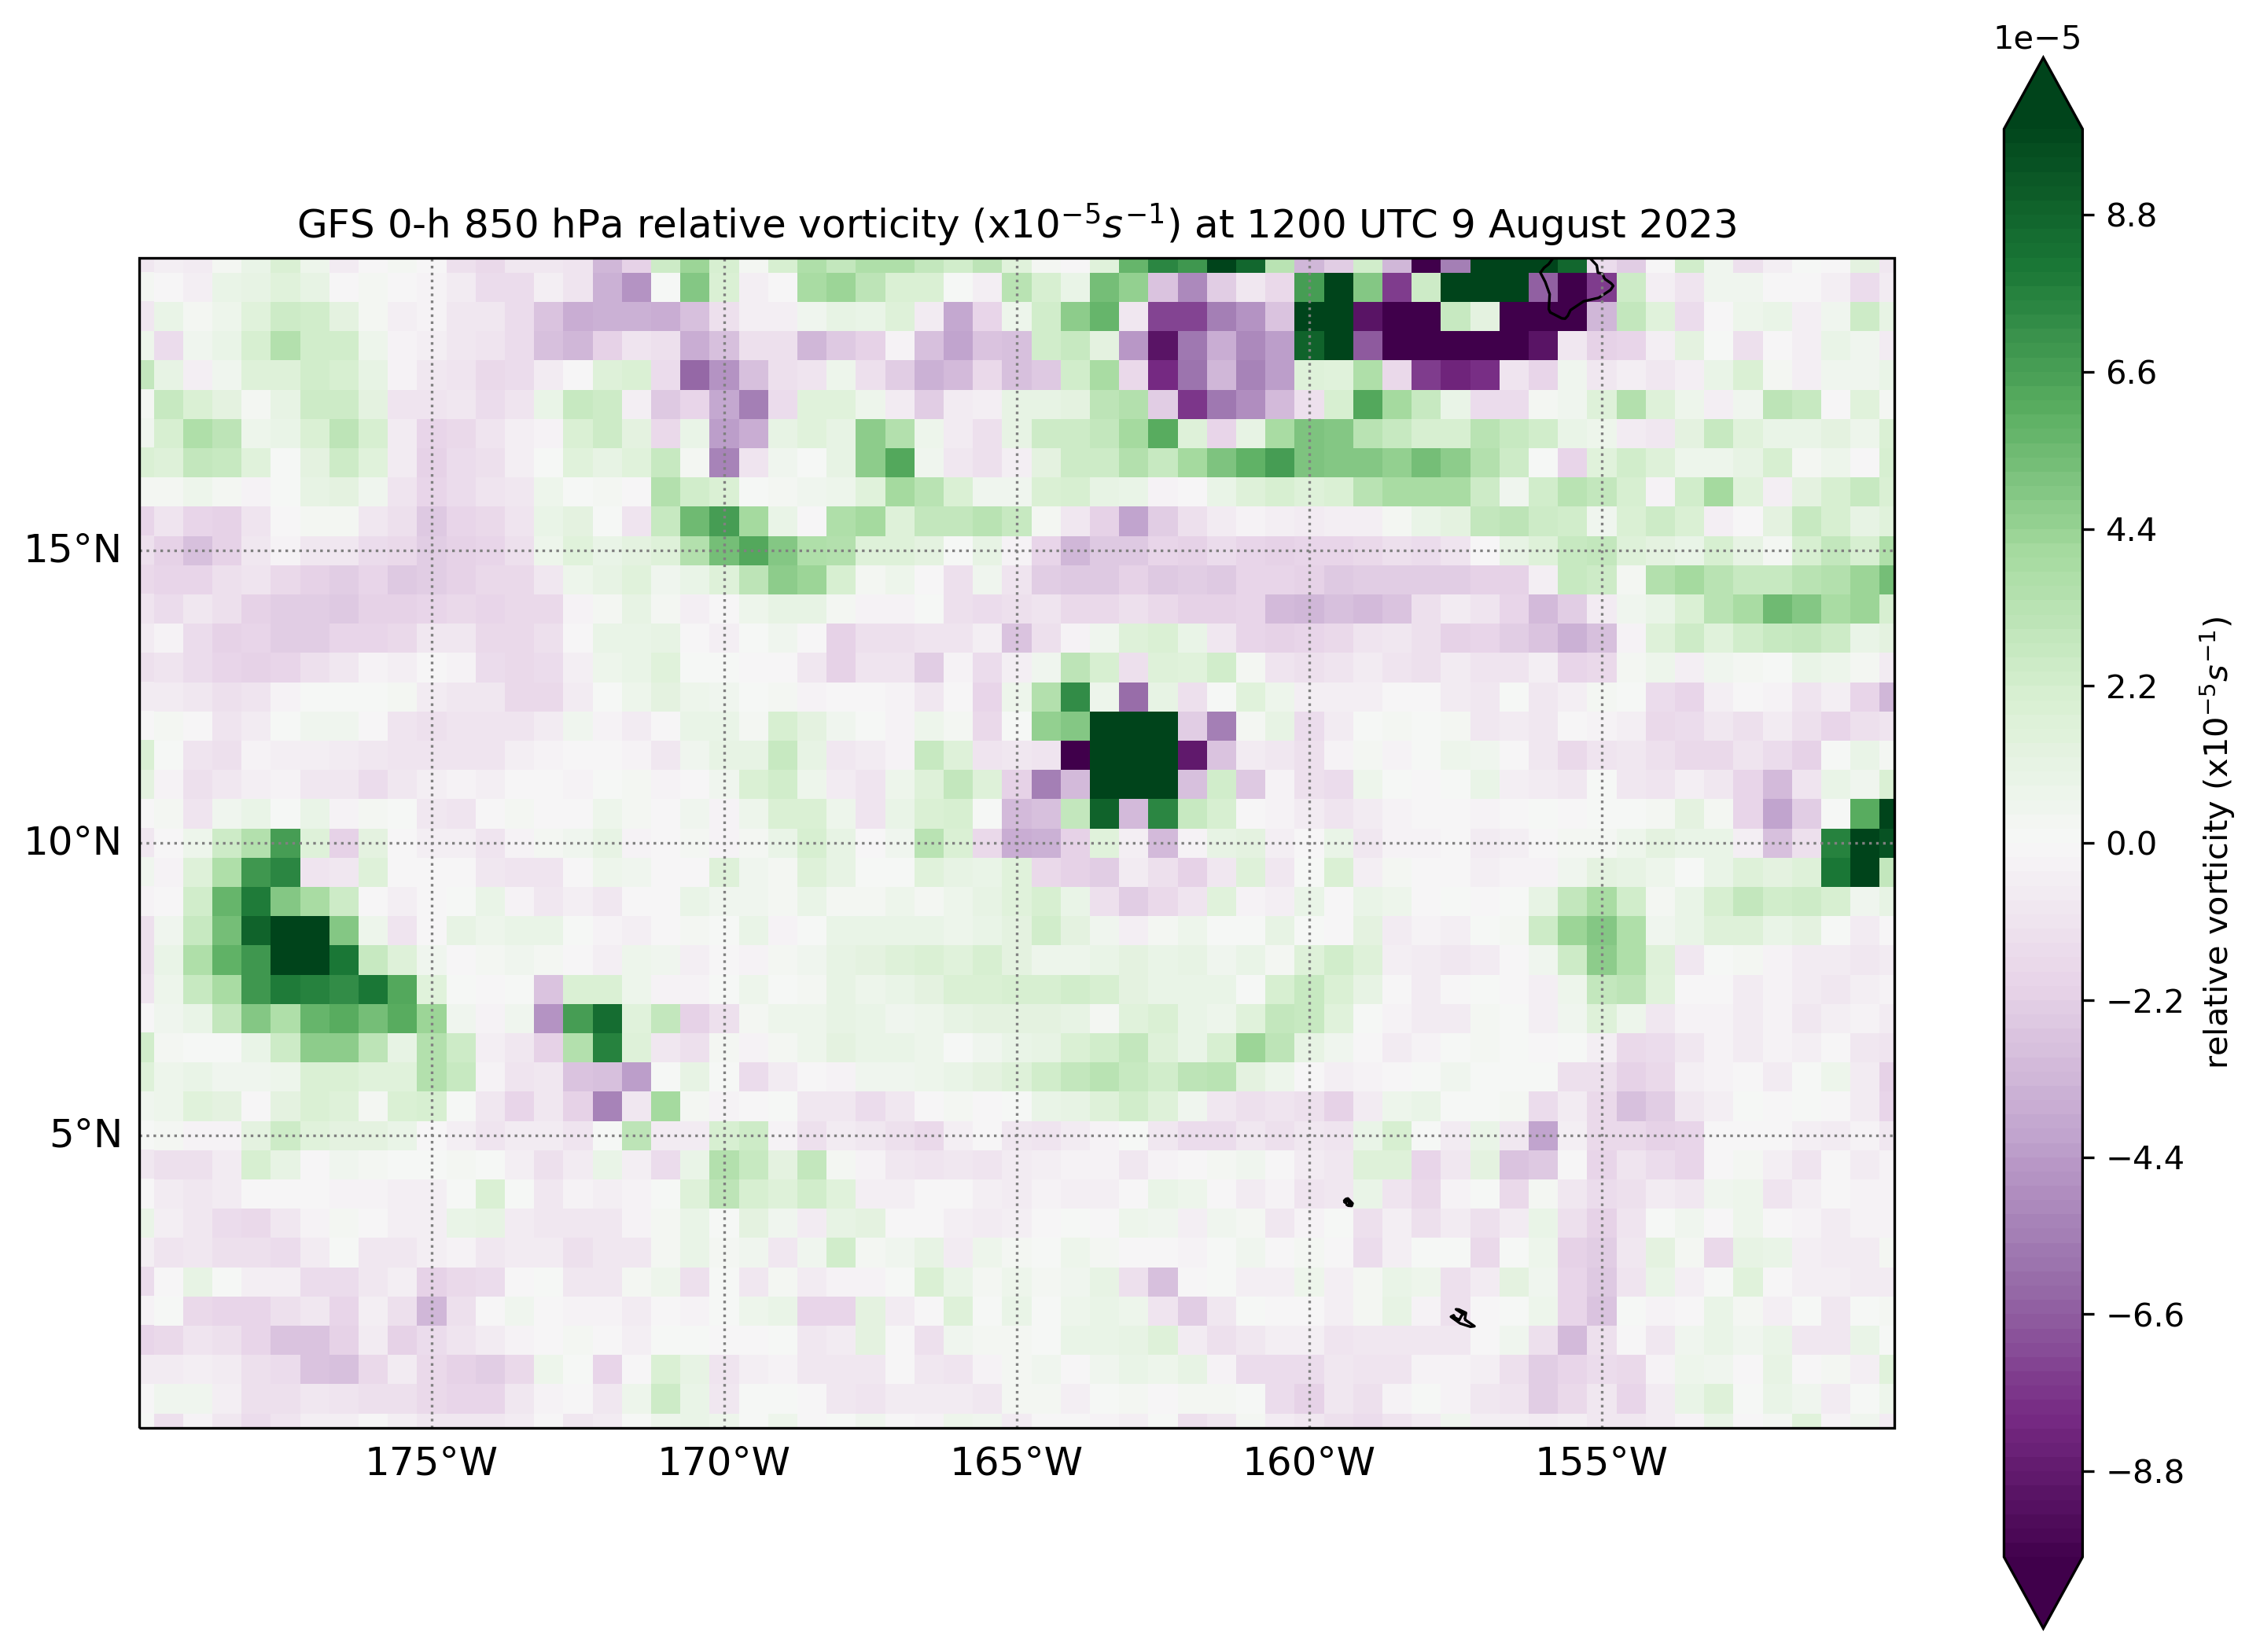

In [4]:
# Create a figure instance.
fig = plt.figure(figsize=(12,9), dpi=300.)

# Create a set of axes for the figure and set
# its map projection to that of the input data.
ax = plt.axes(projection=crs.PlateCarree())

# Add country borders and coastlines.
countries = NaturalEarthFeature(category="cultural", scale="50m",
                                      facecolor="none",
                                      name="admin_0_countries")
ax.add_feature(countries, linewidth=.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)

# Compute the 850 hPa relative vorticity.
vort850 = mpcalc.vorticity(u, v)

# Plot the 850 hPa relative vorticity using xarray's plot functionality.
plot = vort850.plot(levels=np.arange(-1.e-4, 1.e-4, 0.2e-5), cmap=get_cmap('PRGn'), transform=crs.PlateCarree(), cbar_kwargs={'label':'relative vorticity (x$10^{-5} s^{-1}$)', 'shrink': 0.98})

# Set the map's extent to cover just Hurricane Dora.
ax.set_extent([-180.,-150.,0.,20.],crs=crs.PlateCarree())

# Add latitude/longitude gridlines.
gridlines = ax.gridlines(color="grey", linestyle="dotted", draw_labels=True)
gridlines.xlabels_top = False
gridlines.ylabels_right = False
gridlines.xlocator = mticker.FixedLocator(np.arange(-180.,149.,5.))
gridlines.ylocator = mticker.FixedLocator(np.arange(0.,21.,5.))
gridlines.xlabel_style = {'size':12, 'color':'black'}
gridlines.ylabel_style = {'size':12, 'color':'black'}
gridlines.xformatter = LONGITUDE_FORMATTER
gridlines.yformatter = LATITUDE_FORMATTER

# Add a plot title, then show the image.
plt.title("GFS 0-h 850 hPa relative vorticity (x$10^{-5} s^{-1}$) at 1200 UTC 9 August 2023")
plt.show()

Let's also create a plot of 850 hPa divergence over this region.

/opt/tljh/user/lib/python3.7/site-packages/pint/quantity.py:1309: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `g

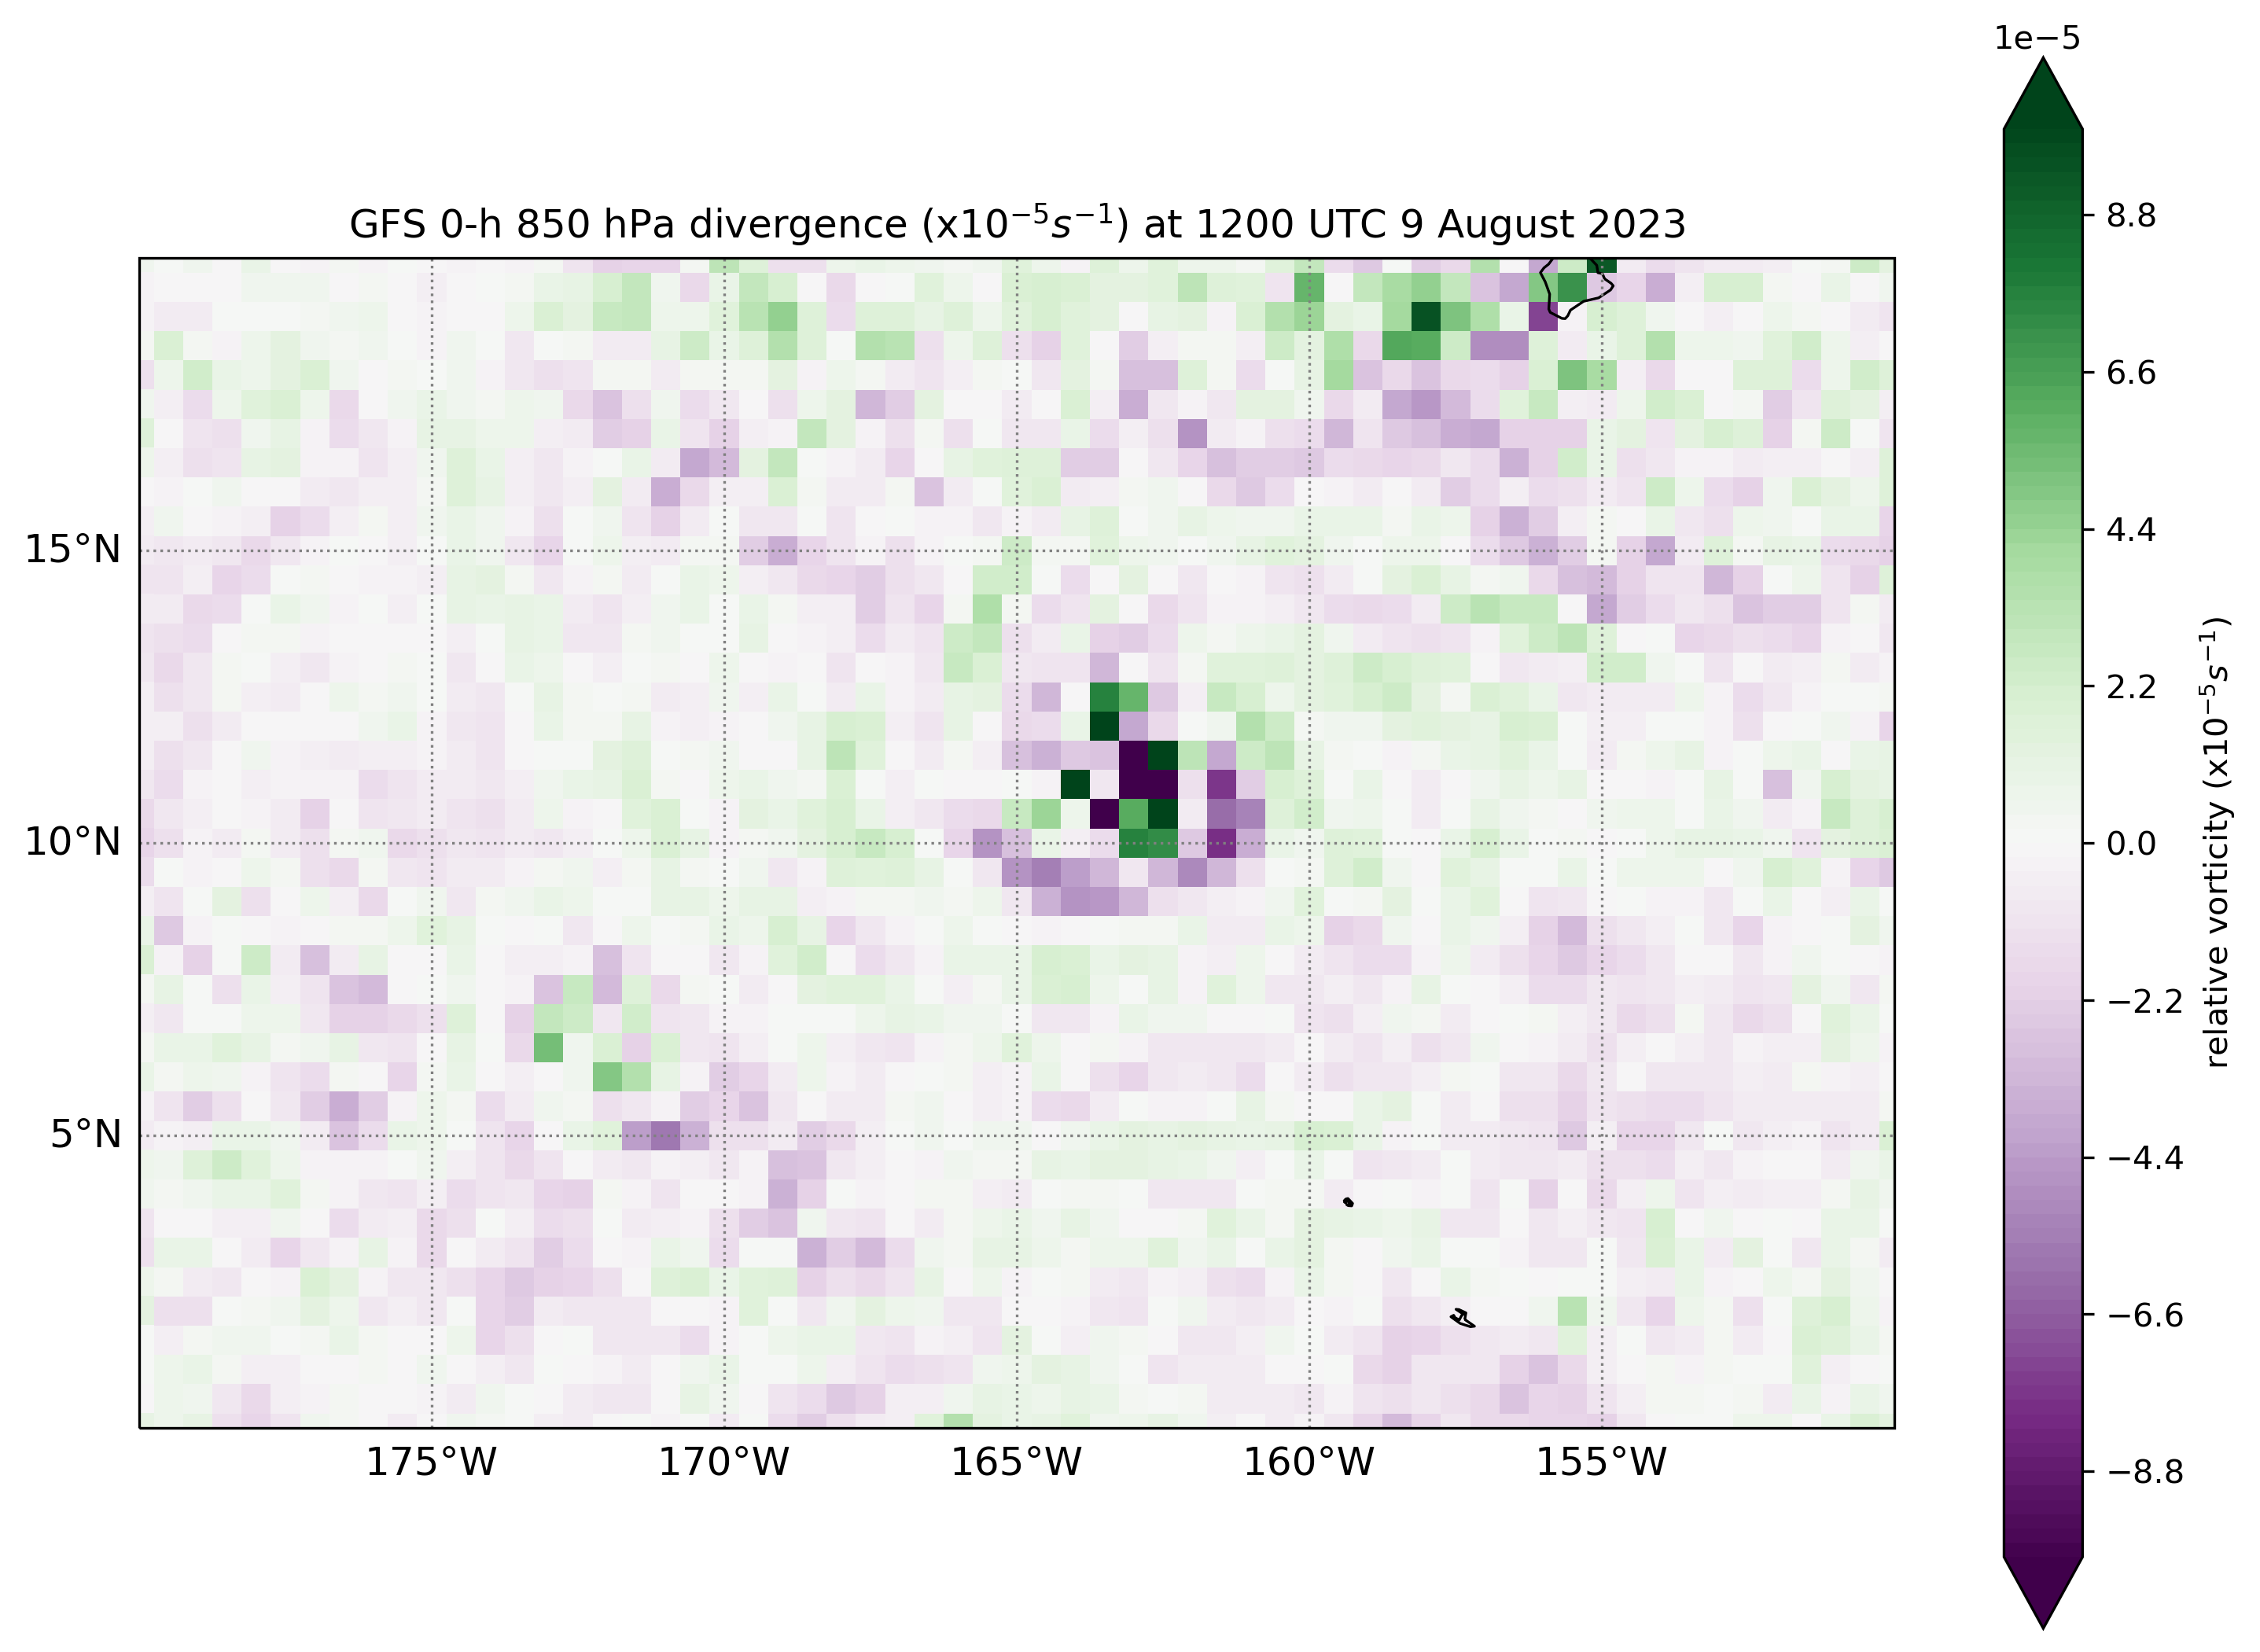

In [5]:
# Create a figure instance.
fig = plt.figure(figsize=(12,9), dpi=300.)

# Create a set of axes for the figure and set
# its map projection to that of the input data.
ax = plt.axes(projection=crs.PlateCarree())

# Add country borders and coastlines.
countries = NaturalEarthFeature(category="cultural", scale="50m",
                                      facecolor="none",
                                      name="admin_0_countries")
ax.add_feature(countries, linewidth=.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)

# Compute the 850 hPa divergence.
div850 = mpcalc.divergence(u, v)

# Plot the 850 hPa divergence using xarray's plot functionality.
plot = div850.plot(levels=np.arange(-1.e-4, 1.e-4, 0.2e-5), cmap=get_cmap('PRGn'), transform=crs.PlateCarree(), cbar_kwargs={'label':'relative vorticity (x$10^{-5} s^{-1}$)', 'shrink': 0.98})

# Set the map's extent to cover just Hurricane Dora.
ax.set_extent([-180.,-150.,0.,20.],crs=crs.PlateCarree())

# Add latitude/longitude gridlines.
gridlines = ax.gridlines(color="grey", linestyle="dotted", draw_labels=True)
gridlines.xlabels_top = False
gridlines.ylabels_right = False
gridlines.xlocator = mticker.FixedLocator(np.arange(-180.,149.,5.))
gridlines.ylocator = mticker.FixedLocator(np.arange(0.,21.,5.))
gridlines.xlabel_style = {'size':12, 'color':'black'}
gridlines.ylabel_style = {'size':12, 'color':'black'}
gridlines.xformatter = LONGITUDE_FORMATTER
gridlines.yformatter = LATITUDE_FORMATTER

# Add a plot title, then show the image.
plt.title("GFS 0-h 850 hPa divergence (x$10^{-5} s^{-1}$) at 1200 UTC 9 August 2023")
plt.show()

Hurricane Dora was located at 11.4°N, 163.1°W at 1200 UTC 9 August 2023. The plots above shows that Dora is a fairly small hurricane, with cyclonic relative vorticity that can reliably be ascribed to Dora located between 5-13.5°N, 169-158°W. The divergence field is noisier, with unexpected strong divergence near Dora's center, albeit with convergence limited to a smaller area. Nevertheless, for consitency, we'll use the same box (5-13.5°N, 169-158°W) to invert the vorticity and divergence, with each field set to zero outside of this box.

In [6]:
# Note the need to use 0->360° rather than -180->180° longitude in defining the mask.
mask = ((vort850.latitude <= 13.5) & (vort850.latitude >= 5.0) & (vort850.longitude <= 202.) & (vort850.longitude >= 191.))
vortmask = vort850.where(mask)
vortmask = vortmask.fillna(0.0)
divmask = div850.where(mask)
divmas = div850.fillna(0.0)

We now want to compute the non-divergent (i.e., that associated with rotation) and irrotational (i.e., that associated with divergence) wind components:
<ul>
    <li>The relative vorticity is equal to the Laplacian of the streamfunction on a horizontal surface. Solving this Poisson equation and using the relationship between the streamfunction and horizontal wind components, we can obtain expressions for the u- and v-components of the non-divergent wind in terms of the relative vorticity. The equations below follow Oertel and Schemm (2021, QJRMS), specifically their Eqns. (8) and (9).</li>
    <li>The divergence is equal to the Laplacian of the velocity potential on a horizontal surface. Solving this Poission equation and using the relationship between the velocity potential and horizontal wind components, we can obtain expressions for the u- and v-components of the irrotational wind in temrs of the divergence. The equations below follow Oertel and Schemm (2021, QJRMS), specifically their Eqns. (10) and (11).</li>

We start by computing the horizontal distance between grid points in the data.

In [7]:
dx, dy = mpcalc.lat_lon_grid_deltas(vortmask.longitude, vortmask.latitude)
dx = np.abs(dx)
dy = np.abs(dy)

Next, we create variables to store the spatially varying non-divergent (upsi, vpsi) and irrotational (uchi, vchi) wind components.

In [8]:
upsi = xr.zeros_like(vortmask)
vpsi = xr.zeros_like(vortmask)
uchi = xr.zeros_like(divmask)
vchi = xr.zeros_like(divmask)

We want to compute the contribution of the vorticity and divergence within our bounding box to the non-divergent and irrotational wind components, respectively, across a slightly larger area than our bounding box. To do so, we need to find the indices of our bounding box (corresponding to 5-13.5°N, 158-169°W, as above) and of the desired larger subset of the GFS grid. We want this to be a bit larger than the map extent above so that we can fully encompass Hawaii, so let's use 0-30°N, 140-180°W for this larger subset.

In [9]:
x_ll = list(vortmask.longitude.values).index(191.0)
x_ur = list(vortmask.longitude.values).index(202.0)
y_ll = list(vortmask.latitude.values).index(5.0)
y_ur = list(vortmask.latitude.values).index(13.5)

x_ll_subset = list(vortmask.longitude.values).index(180.0)
x_ur_subset = list(vortmask.longitude.values).index(220.0)
y_ll_subset = list(vortmask.latitude.values).index(0.0)
y_ur_subset = list(vortmask.latitude.values).index(30.0)

Now that we have our bounding box, we can iteratively compute the non-divergent and irrotational wind components. Note that since y = 1 is the top latitude (90°N) rather than bottom latitude (90°S), the loop in latitude is top-down.

<b>Note that the data are stored with latitude as the first dimension and longitude as the second dimension, thus the indexing below is cast in terms of j,i rather than the traditional i,j.</b>

In [10]:
# Iterate over each model grid point (larger area).
# i and j refer to x and y in the Oertel and Schemm (2021) equations.
for i in range(x_ll_subset, x_ur_subset):
    for j in range(y_ur_subset, y_ll_subset): 

# Computing the contribution to each other grid point (masked area).
# x1 and y1 refer to x' and y' in the Oertel and Schemm (2021) equations.
        for x1 in range(x_ll, x_ur):
            for y1 in range(y_ur, y_ll):
                outer_point = [i,j]
                inner_point = [x1,y1]
                
                if inner_point != outer_point:
                    
                # Compute x-x', y-y', and r^2...
                    xdiff = (i-x1)*dx[y1,x1].magnitude
                    ydiff = (j-y1)*dy[y1,x1].magnitude
                    rsq = (xdiff*xdiff) + (ydiff*ydiff)
                
                # Compute the non-divergent flow contribution.
                    upsi[j,i] += vortmask[y1,x1].values * -1.0 * (ydiff / rsq) * dx[y1,x1].magnitude * dy[y1,x1].magnitude
                    vpsi[j,i] += vortmask[y1,x1].values * (xdiff / rsq) * dx[y1,x1].magnitude * dy[y1,x1].magnitude
                
                # Compute the irrotational flow contribution.
                    uchi[j,i] += divmask[y1,x1].values * (xdiff / rsq) * dx[y1,x1].magnitude * dy[y1,x1].magnitude
                    vchi[j,i] += divmask[y1,x1].values * (ydiff / rsq) * dx[y1,x1].magnitude * dy[y1,x1].magnitude

        # Once all points have been iterated over, scale by 1/2pi.
        upsi[j,i] = (1/(2*np.pi)) * upsi[j,i]
        vpsi[j,i] = (1/(2*np.pi)) * vpsi[j,i]
        uchi[j,i] = (1/(2*np.pi)) * uchi[j,i]
        vchi[j,i] = (1/(2*np.pi)) * vchi[j,i]

Now that we have the non-divergent and irrotational wind components, let's create a few plots: the non-divergent wind magnitude, the irrotational wind magnitude, and the sum of the two!

/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:877: ShapelyD

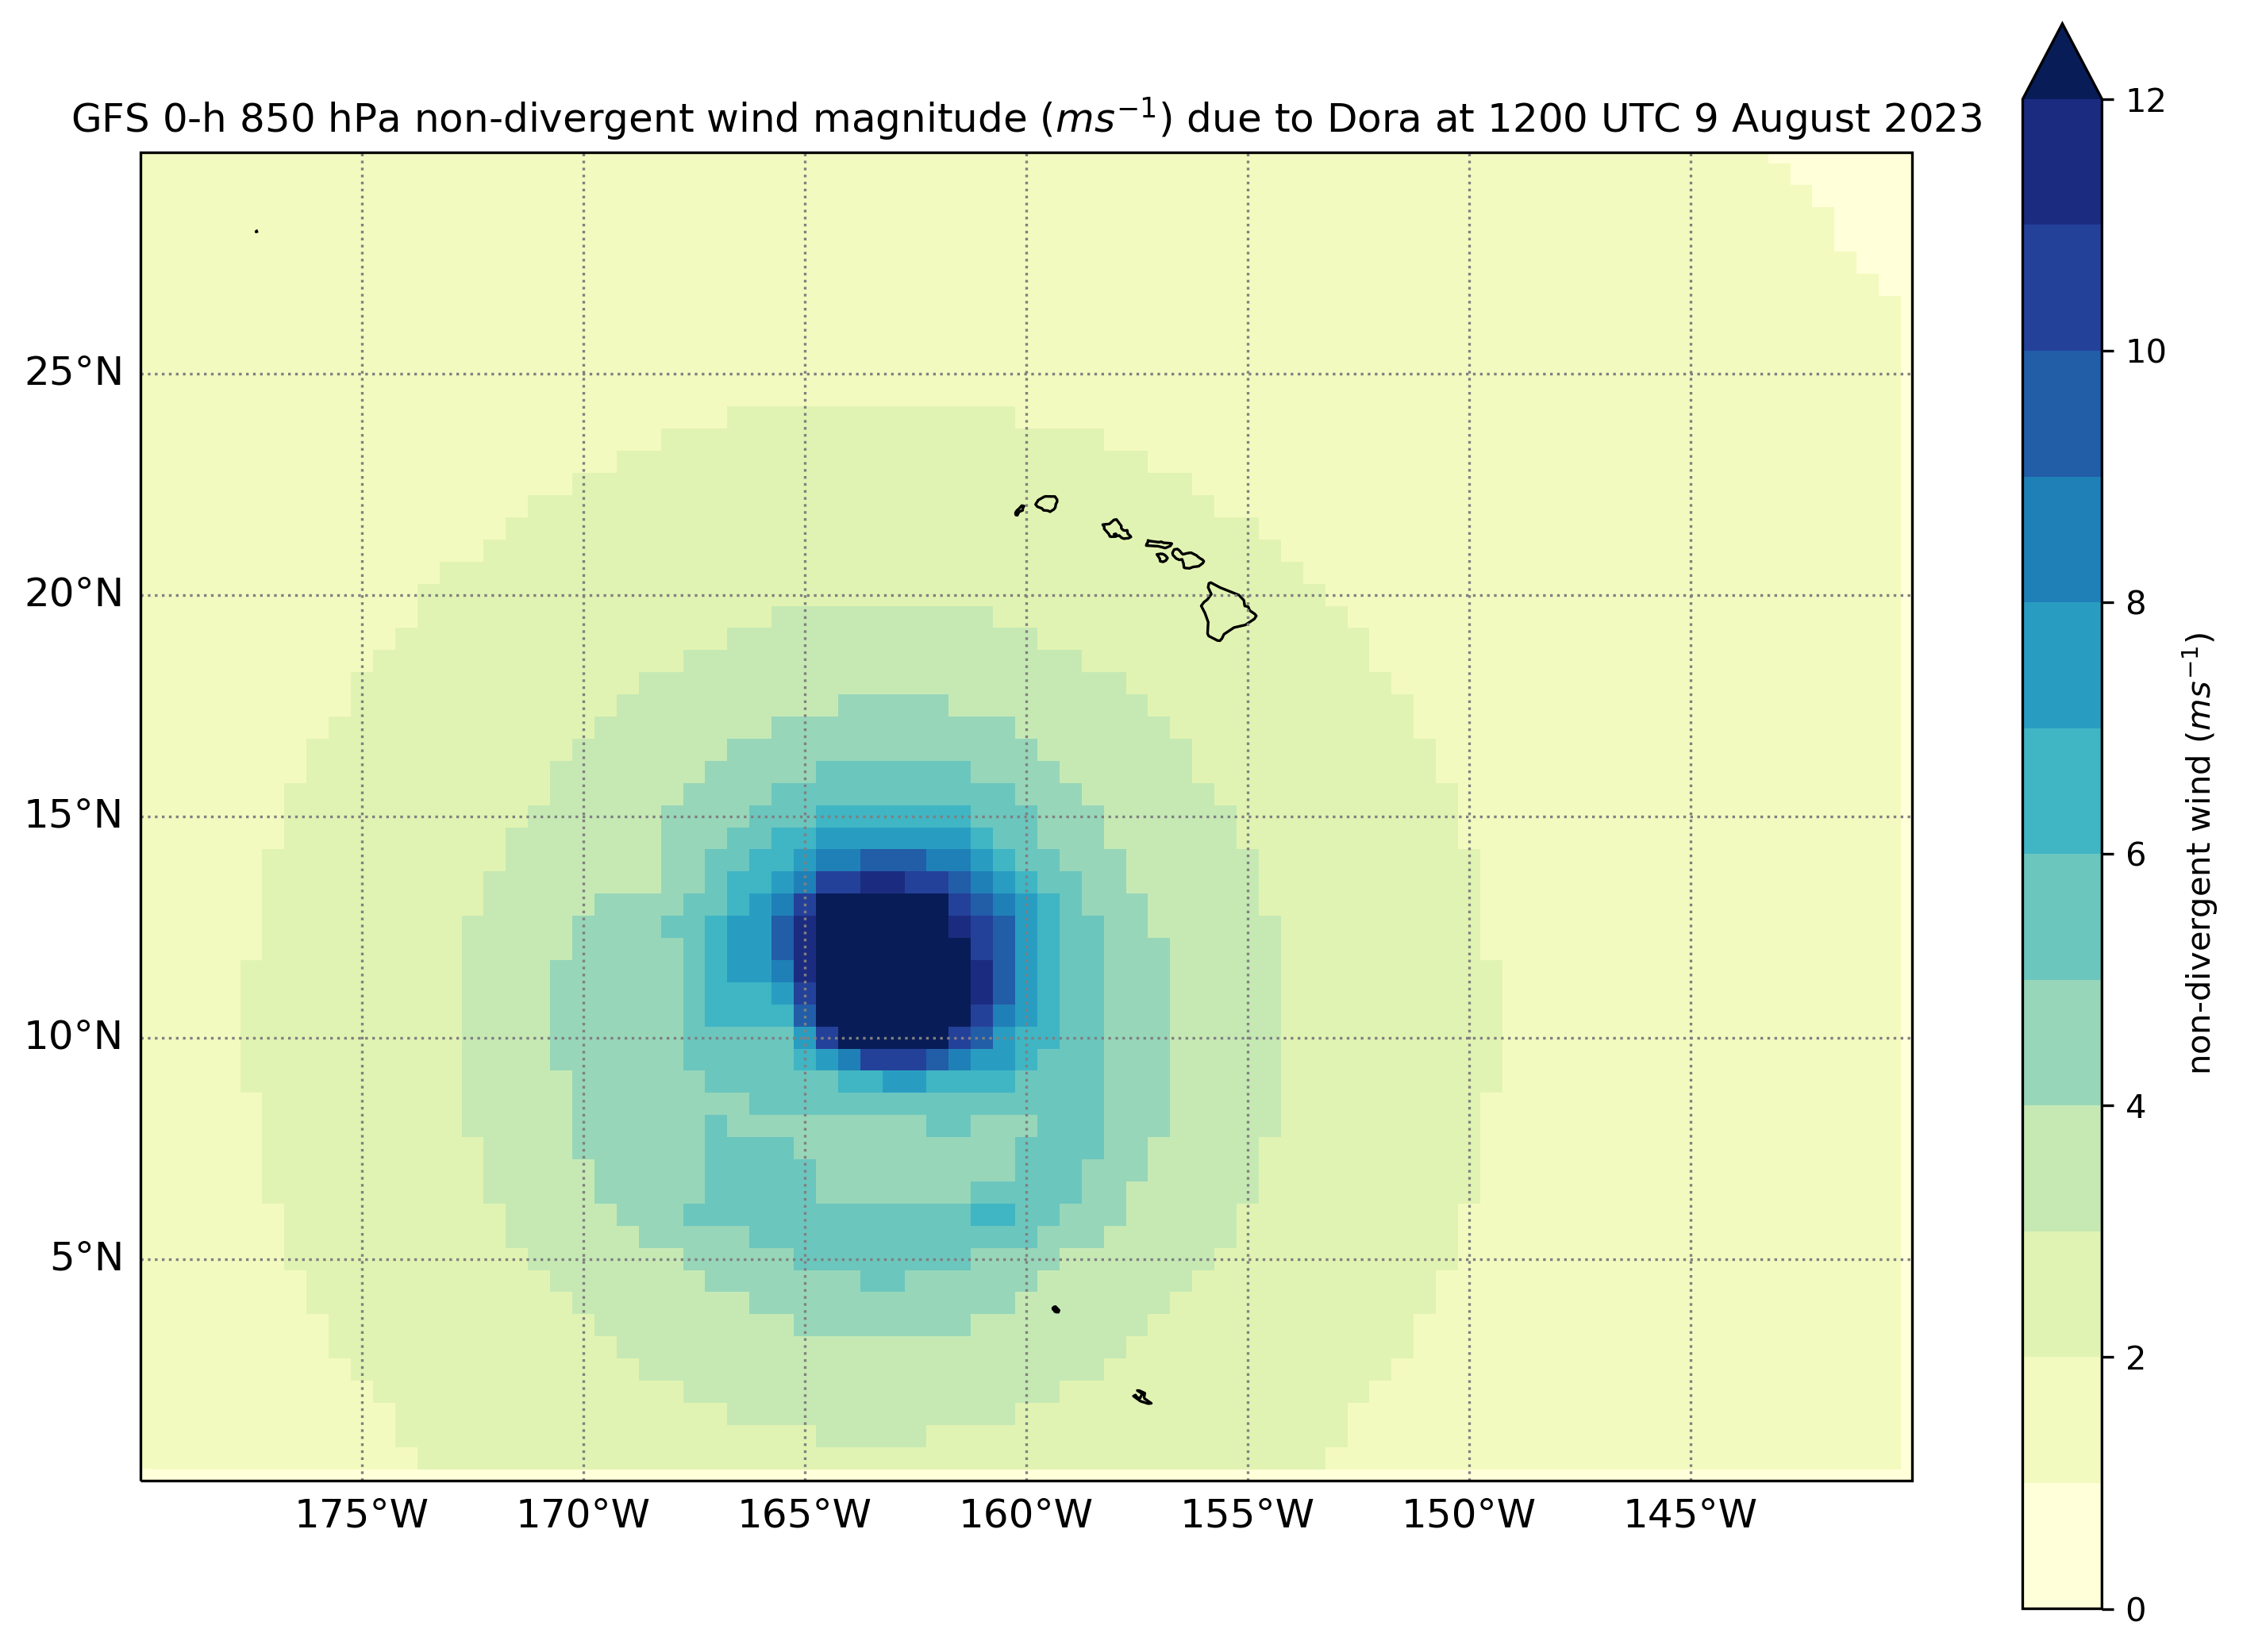

In [11]:
# Create a figure instance.
fig = plt.figure(figsize=(12,9), dpi=300.)

# Create a set of axes for the figure and set
# its map projection to that of the input data.
ax = plt.axes(projection=crs.PlateCarree())

# Add country borders and coastlines.
countries = NaturalEarthFeature(category="cultural", scale="50m",
                                      facecolor="none",
                                      name="admin_0_countries")
ax.add_feature(countries, linewidth=.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)

# Compute the magnitude of the non-divergent component of the 850 hPa wind.
nd_spd = np.sqrt(upsi**2 + vpsi**2)

# Plot this using xarray's plot functionality.
plot = nd_spd.plot(levels=np.arange(0., 13., 1.), cmap=get_cmap('YlGnBu'), transform=crs.PlateCarree(), cbar_kwargs={'label':'non-divergent wind ($m s^{-1}$)', 'shrink': 0.98})

# Set the map's extent to match that over which we computed the non-divergent wind.
ax.set_extent([-180.,-140.,0.,30.],crs=crs.PlateCarree())

# Add latitude/longitude gridlines.
gridlines = ax.gridlines(color="grey", linestyle="dotted", draw_labels=True)
gridlines.xlabels_top = False
gridlines.ylabels_right = False
gridlines.xlocator = mticker.FixedLocator(np.arange(-180.,139.,5.))
gridlines.ylocator = mticker.FixedLocator(np.arange(0.,31.,5.))
gridlines.xlabel_style = {'size':12, 'color':'black'}
gridlines.ylabel_style = {'size':12, 'color':'black'}
gridlines.xformatter = LONGITUDE_FORMATTER
gridlines.yformatter = LATITUDE_FORMATTER

# Add a plot title, then show the image.
plt.title("GFS 0-h 850 hPa non-divergent wind magnitude ($m s^{-1}$) due to Dora at 1200 UTC 9 August 2023")
plt.show()

/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:877: ShapelyD

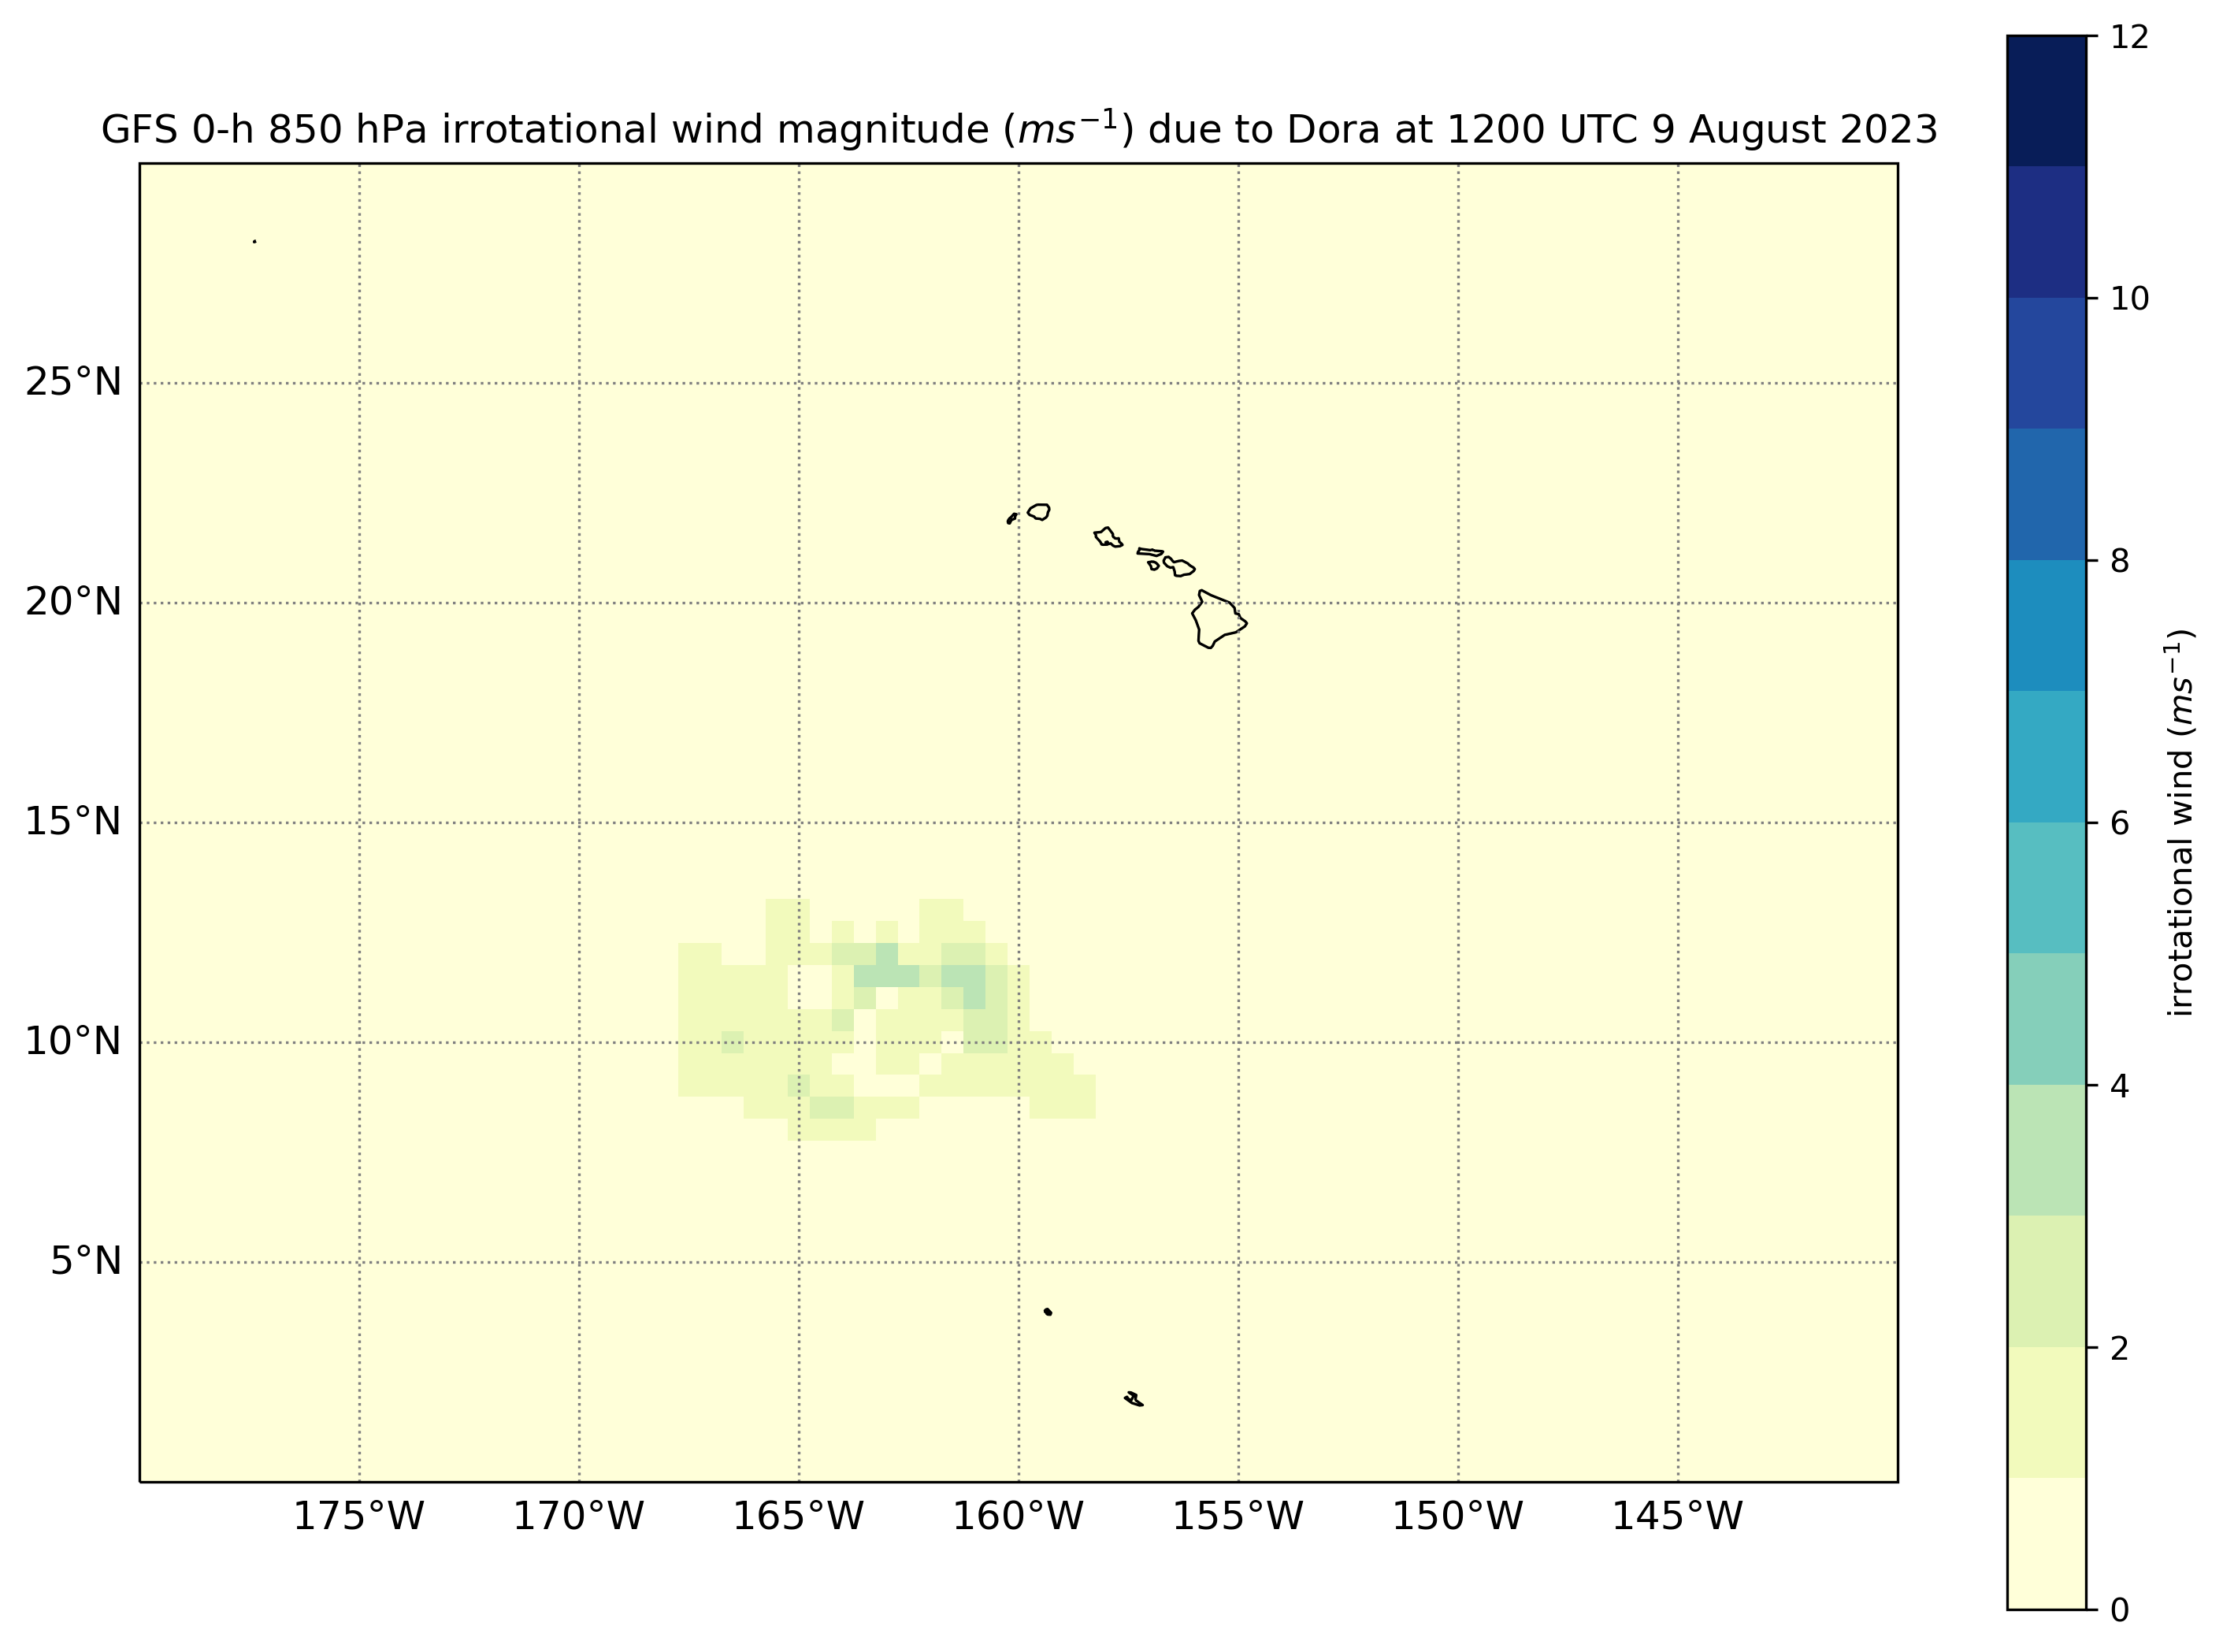

In [12]:
# Create a figure instance.
fig = plt.figure(figsize=(12,9), dpi=300.)

# Create a set of axes for the figure and set
# its map projection to that of the input data.
ax = plt.axes(projection=crs.PlateCarree())

# Add country borders and coastlines.
countries = NaturalEarthFeature(category="cultural", scale="50m",
                                      facecolor="none",
                                      name="admin_0_countries")
ax.add_feature(countries, linewidth=.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)

# Compute the magnitude of the irrotational component of the 850 hPa wind.
irr_spd = np.sqrt(uchi**2 + vchi**2)

# Plot this using xarray's plot functionality.
plot = irr_spd.plot(levels=np.arange(0., 13., 1.), cmap=get_cmap('YlGnBu'), transform=crs.PlateCarree(), cbar_kwargs={'label':'irrotational wind ($m s^{-1}$)', 'shrink': 0.98})

# Set the map's extent to match that over which we computed the irrotational wind.
ax.set_extent([-180.,-140.,0.,30.],crs=crs.PlateCarree())

# Add latitude/longitude gridlines.
gridlines = ax.gridlines(color="grey", linestyle="dotted", draw_labels=True)
gridlines.xlabels_top = False
gridlines.ylabels_right = False
gridlines.xlocator = mticker.FixedLocator(np.arange(-180.,139.,5.))
gridlines.ylocator = mticker.FixedLocator(np.arange(0.,31.,5.))
gridlines.xlabel_style = {'size':12, 'color':'black'}
gridlines.ylabel_style = {'size':12, 'color':'black'}
gridlines.xformatter = LONGITUDE_FORMATTER
gridlines.yformatter = LATITUDE_FORMATTER

# Add a plot title, then show the image.
plt.title("GFS 0-h 850 hPa irrotational wind magnitude ($m s^{-1}$) due to Dora at 1200 UTC 9 August 2023")
plt.show()

/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:877: ShapelyD

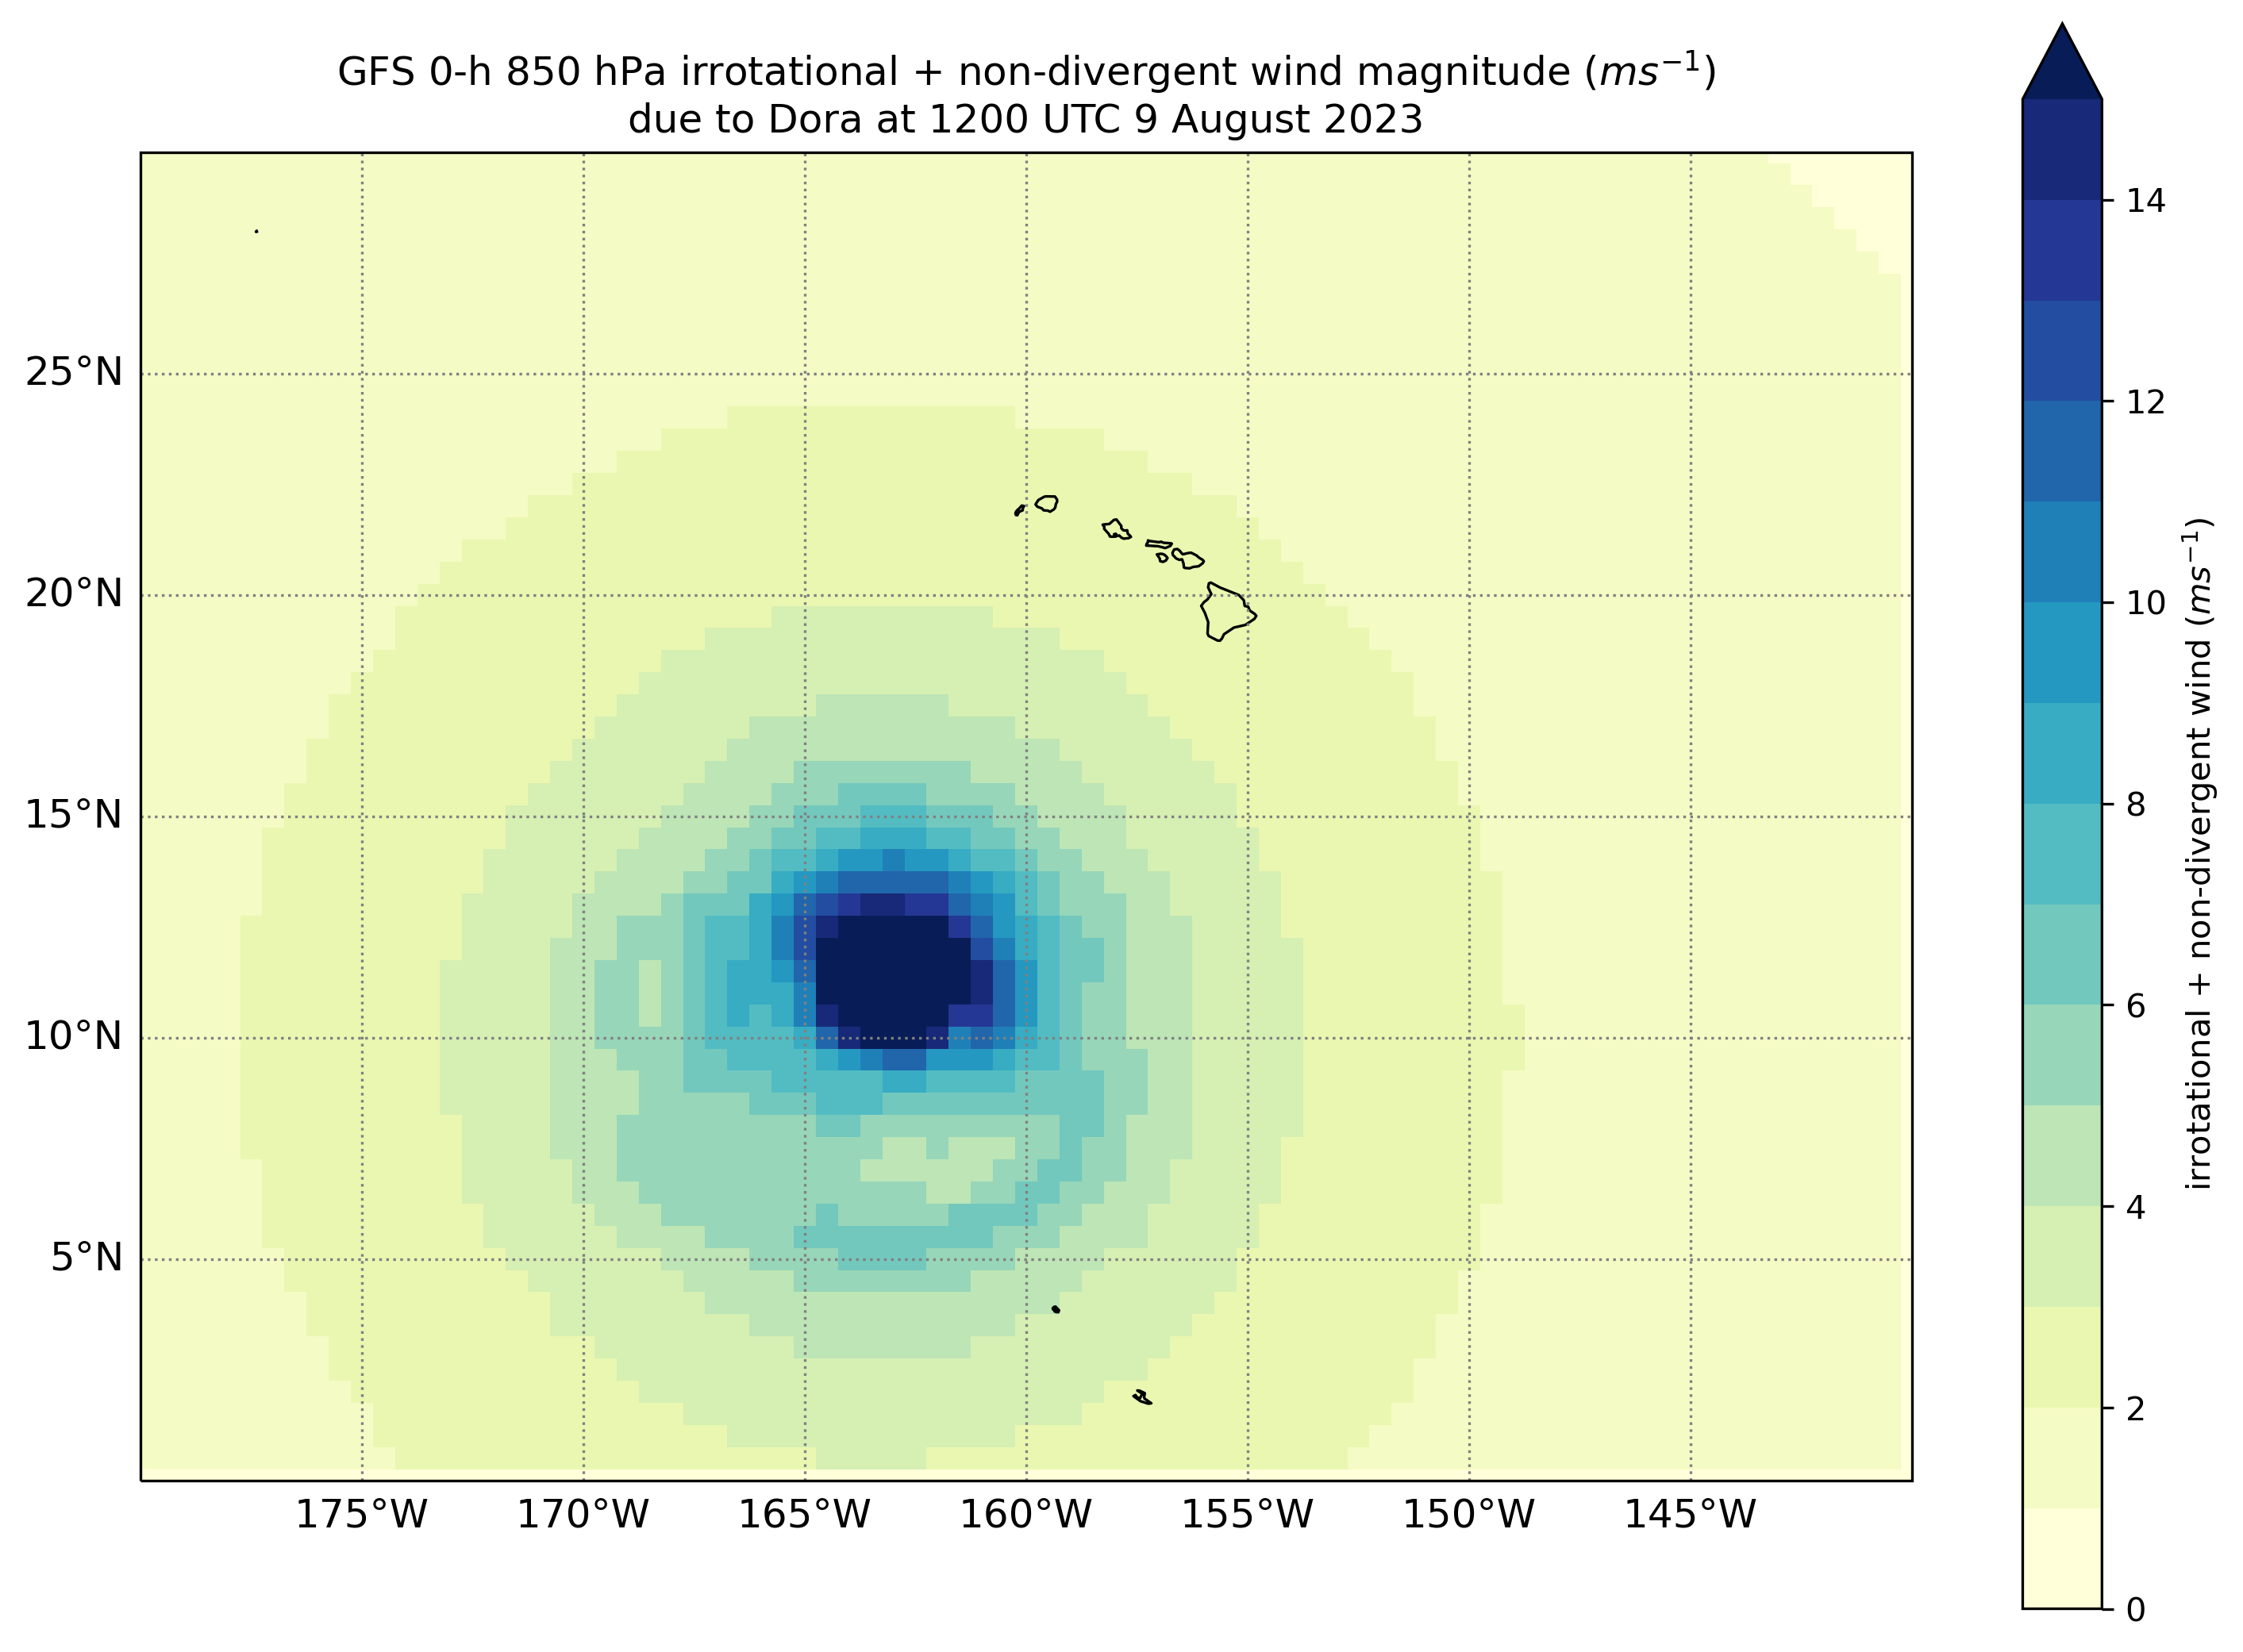

In [14]:
# Create a figure instance.
fig = plt.figure(figsize=(12,9), dpi=300.)

# Create a set of axes for the figure and set
# its map projection to that of the input data.
ax = plt.axes(projection=crs.PlateCarree())

# Add country borders and coastlines.
countries = NaturalEarthFeature(category="cultural", scale="50m",
                                      facecolor="none",
                                      name="admin_0_countries")
ax.add_feature(countries, linewidth=.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)

# Add the non-divergent and irrotational wind magnitudes.
tot_spd = nd_spd + irr_spd

# Plot this using xarray's plot functionality.
plot = tot_spd.plot(levels=np.arange(0., 16., 1.), cmap=get_cmap('YlGnBu'), transform=crs.PlateCarree(), cbar_kwargs={'label':'irrotational + non-divergent wind ($m s^{-1}$)', 'shrink': 0.98})

# Set the map's extent to match that over which we computed the irrotational wind.
ax.set_extent([-180.,-140.,0.,30.],crs=crs.PlateCarree())

# Add latitude/longitude gridlines.
gridlines = ax.gridlines(color="grey", linestyle="dotted", draw_labels=True)
gridlines.xlabels_top = False
gridlines.ylabels_right = False
gridlines.xlocator = mticker.FixedLocator(np.arange(-180.,139.,5.))
gridlines.ylocator = mticker.FixedLocator(np.arange(0.,31.,5.))
gridlines.xlabel_style = {'size':12, 'color':'black'}
gridlines.ylabel_style = {'size':12, 'color':'black'}
gridlines.xformatter = LONGITUDE_FORMATTER
gridlines.yformatter = LATITUDE_FORMATTER

# Add a plot title, then show the image.
plt.title("GFS 0-h 850 hPa irrotational + non-divergent wind magnitude ($m s^{-1}$)\ndue to Dora at 1200 UTC 9 August 2023")
plt.show()